## Obligatorio: Integencia Artificial Generativa.

### Proyecto: Animals with attributes CVAE

### Integrantes:

Leandro Cardoso - 166267

Felipe Schramm - 343028

Martin Rizzo - 343631

In [82]:
import pandas as pd
import os
#import kagglehub
from PIL import Image

import torchvision.transforms.functional as F
import numpy as np
import random
import math


import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)
from collections import Counter
#from utils import train, evaluate, plot_taining

In [83]:
dataset_path = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2"

In [84]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.colheader_justify", "left")

In [85]:
labels_path = os.path.join(dataset_path, "classes.txt")  # Cambiar según el archivo disponible
classes = pd.read_csv(labels_path, header=None)  # Configurar header según el formato del archivo
print("Clases en el dataset:")
print(classes)

attr_path = os.path.join(dataset_path, "predicates.txt")
features = pd.read_csv(attr_path, header=None)
print("Atributos de las clases:")
print(features)

Clases en el dataset:
   0                       
0               1\tantelope
1           2\tgrizzly+bear
2           3\tkiller+whale
3                 4\tbeaver
4              5\tdalmatian
5            6\tpersian+cat
6                  7\thorse
7        8\tgerman+shepherd
8             9\tblue+whale
9           10\tsiamese+cat
10                11\tskunk
11                 12\tmole
12                13\ttiger
13         14\thippopotamus
14              15\tleopard
15                16\tmoose
16        17\tspider+monkey
17       18\thumpback+whale
18             19\telephant
19              20\tgorilla
20                   21\tox
21                  22\tfox
22                23\tsheep
23                 24\tseal
24           25\tchimpanzee
25              26\thamster
26             27\tsquirrel
27           28\trhinoceros
28               29\trabbit
29                  30\tbat
30              31\tgiraffe
31                 32\twolf
32            33\tchihuahua
33                  34\tra

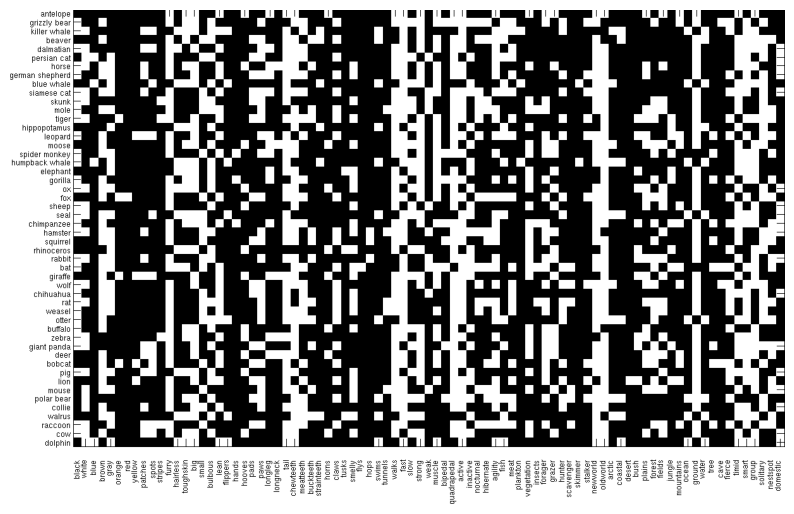

In [86]:
matrix = dataset_path + "/predicate-matrix.png"
img = Image.open(matrix)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [87]:
binary_matrix = dataset_path + "/predicate-matrix-binary.txt"
binary_matrix = np.loadtxt(binary_matrix)
print("Matriz de valores binarios:")
print(binary_matrix)

Matriz de valores binarios:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 1. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]]


In [88]:
continuous_matrix = dataset_path + "/predicate-matrix-continuous.txt"
continuous_matrix = np.loadtxt(continuous_matrix)
print("Matriz de valores continuos:")
print(continuous_matrix)

Matriz de valores continuos:
[[-1.   -1.   -1.   ...  2.35  9.7   8.38]
 [39.25  1.39  0.   ... 58.64 20.14 11.39]
 [83.4  64.79  0.   ... 15.77 13.41 15.42]
 ...
 [63.57 43.1   0.   ... 35.95 28.26  5.  ]
 [55.31 55.46  0.   ...  5.04 18.89 72.99]
 [10.22 21.53 27.73 ...  3.96 14.05 37.98]]


In [89]:
def load_classes(classes_file):
    """
    Carga el archivo classes.txt y devuelve un diccionario {número_clase: nombre_clase}.
    """
    classes = {}
    with open(classes_file, 'r') as f:
        for line in f:
            class_id, class_name = line.strip().split()
            classes[int(class_id)] = class_name
    return classes

def load_attributes(predicates_file):
    """
    Carga el archivo predicates.txt y devuelve un diccionario {número_atributo: nombre_atributo}.
    """
    attributes = {}
    with open(predicates_file, 'r') as f:
        for line in f:
            attribute_id, attribute_name = line.strip().split()
            attributes[int(attribute_id)] = attribute_name
    return attributes

def filter_predicate_matrix(predicate_matrix_file, selected_classes, selected_attributes, classes_dict, attributes_dict):
    """
    Filtra la matriz de predicados para incluir solo las clases y atributos seleccionados.
    """
    # Cargar la matriz completa
    predicate_matrix = np.loadtxt(predicate_matrix_file, dtype=int)
    
    # Obtener índices de las clases y atributos seleccionados
    class_indices = [k for k, v in classes_dict.items() if v in selected_classes]
    attribute_indices = [k for k, v in attributes_dict.items() if v in selected_attributes]
    
    # Filtrar la matriz
    filtered_matrix = predicate_matrix[np.ix_(class_indices, attribute_indices)]
    
    # Crear nuevos diccionarios filtrados
    filtered_classes = {k: classes_dict[k] for k in class_indices}
    filtered_attributes = {k: attributes_dict[k] for k in attribute_indices}
    
    return filtered_matrix, filtered_classes, filtered_attributes

# Función para cargar y filtrar las clases y atributos
def load_filtered_data(predicate_matrix_file, selected_classes, selected_attributes, classes_dict, attributes_dict):
    # los indices de las clases y atributos van de 1 a N y los arrays de numpy van de 0 a N-1. 
    # Por lo que es necesario ajustar los numeros asociados a las clases y atributos para que se puedan mapear correctamente en la matriz
    predicate_matrix = np.loadtxt(predicate_matrix_file, dtype=int)
    class_indices = [k-1 for k, v in classes_dict.items() if v in selected_classes]
    attribute_indices = [k-1 for k, v in attributes_dict.items() if v in selected_attributes]
    filtered_matrix = predicate_matrix[np.ix_(class_indices, attribute_indices)]
    filtered_classes = {k: classes_dict[k] for k in (np.array(class_indices)+1)}
    filtered_attributes = {k: attributes_dict[k] for k in (np.array(attribute_indices)+1)}
    return filtered_matrix, filtered_classes, filtered_attributes


In [90]:
# Cargar la matriz completa
#predicate_matrix = np.loadtxt(predicate_matrix_file, dtype=int)
#print(predicate_matrix.shape)
#horse_black = predicate_matrix[6,0]
#print(horse_black)

In [91]:
def reindex_classes_and_attributes(filtered_classes, filtered_attributes):
    """
    Reindexa las clases y atributos seleccionados para que sus índices coincidan con las filas y columnas
    de la matriz filtrada.
    """
    new_class_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_classes.keys())}
    new_attribute_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_attributes.keys())}
    return new_class_indices, new_attribute_indices



In [92]:
# Paths a los archivos
classes_file = labels_path
predicates_file = attr_path
predicate_matrix_file = dataset_path + "/predicate-matrix-binary.txt"

# Cargar datos
classes_dict = load_classes(classes_file)
attributes_dict = load_attributes(predicates_file)
print("Classes dict: ", classes_dict)

# Especificar las clases y atributos seleccionados
selected_classes = ["bat", "skunk", "horse", "sheep"]  # Nombres de las especies
selected_attributes = ["black", "small", "fast", "strong", "white","tail"]  # Nombres de atributos

# Filtrar la matriz
filtered_matrix, filtered_classes, filtered_attributes = load_filtered_data(
    predicate_matrix_file, selected_classes, selected_attributes, classes_dict, attributes_dict
)

# Mostrar resultados
print("Clases seleccionadas:", filtered_classes)
print("Atributos seleccionados:", filtered_attributes)
print("Matriz filtrada:\n", filtered_matrix)

# Reindexar clases y atributos
new_class_indices, new_attribute_indices = reindex_classes_and_attributes(filtered_classes, filtered_attributes)

# Imprimir resultados
print("Nuevos índices para clases:", new_class_indices)
print("Nuevos índices para atributos:", new_attribute_indices)
print()
# Imprimir resultados
print("Clases seleccionadas (reindexadas):", {new_idx: name for old_idx, new_idx in new_class_indices.items() for k, name in filtered_classes.items() if k == old_idx})
print("Atributos seleccionados (reindexados):", {new_idx: name for old_idx, new_idx in new_attribute_indices.items() for k, name in filtered_attributes.items() if k == old_idx})
print("Matriz filtrada:\n", filtered_matrix)

Classes dict:  {1: 'antelope', 2: 'grizzly+bear', 3: 'killer+whale', 4: 'beaver', 5: 'dalmatian', 6: 'persian+cat', 7: 'horse', 8: 'german+shepherd', 9: 'blue+whale', 10: 'siamese+cat', 11: 'skunk', 12: 'mole', 13: 'tiger', 14: 'hippopotamus', 15: 'leopard', 16: 'moose', 17: 'spider+monkey', 18: 'humpback+whale', 19: 'elephant', 20: 'gorilla', 21: 'ox', 22: 'fox', 23: 'sheep', 24: 'seal', 25: 'chimpanzee', 26: 'hamster', 27: 'squirrel', 28: 'rhinoceros', 29: 'rabbit', 30: 'bat', 31: 'giraffe', 32: 'wolf', 33: 'chihuahua', 34: 'rat', 35: 'weasel', 36: 'otter', 37: 'buffalo', 38: 'zebra', 39: 'giant+panda', 40: 'deer', 41: 'bobcat', 42: 'pig', 43: 'lion', 44: 'mouse', 45: 'polar+bear', 46: 'collie', 47: 'walrus', 48: 'raccoon', 49: 'cow', 50: 'dolphin'}
Clases seleccionadas: {7: 'horse', 11: 'skunk', 23: 'sheep', 30: 'bat'}
Atributos seleccionados: {1: 'black', 2: 'white', 16: 'small', 26: 'tail', 40: 'fast', 42: 'strong'}
Matriz filtrada:
 [[1 1 0 1 1 1]
 [1 1 1 1 1 0]
 [1 1 0 0 0 0]
 [

In [93]:
# Transformaciones
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),                          
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [94]:
# Filtrar las imágenes del dataset

def is_valid_image(img_path, filtered_class_names):
    return any(class_name in img_path for class_name in filtered_class_names)

# Dataset personalizado
class AnimalAttributesDataset(Dataset):
    def __init__(self, root, transform, selected_classes, selected_attributes, classes_dict, attributes_dict):
        self.root = root
        self.transform = transform
        self.samples = []
        #self.filtered_matrix = filtered_matrix

        self.filtered_matrix, self.filtered_classes, self.filtered_attributes = load_filtered_data(
            predicate_matrix_file, selected_classes, selected_attributes, classes_dict, attributes_dict
        )
        
        # Crear mapeos de índices originales a nuevos
        class_to_new_idx = {orig_idx: new_idx for new_idx, orig_idx in enumerate(self.filtered_classes)}
        
        for class_idx, class_name in enumerate(self.filtered_classes):
            class_dir = os.path.join(root, classes_dict[class_name])  # Usar nombres de clases
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        self.samples.append((img_path, class_name, self.filtered_matrix[class_idx]))
    

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, img_class, attributes = self.samples[index]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        attributes = torch.tensor(attributes, dtype=torch.float32)
        image_class = torch.tensor(img_class, dtype=torch.int32)
        return image, image_class, attributes

In [95]:
def analyze_class_balance(root, classes_dict):
    """
    Analiza la cantidad de imágenes en cada clase seleccionada recorriendo los directorios.
    """
    class_counts = {}

    for class_idx, class_name in classes_dict.items():
        class_folder = class_name
        class_path = os.path.join(root, class_folder)
        if os.path.isdir(class_path):
            num_files = sum(1 for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
            class_counts[class_folder] = num_files
     # Encuentra la clave del valor mínimo
    min_key = min(class_counts, key=class_counts.get)
    min_value = class_counts[min_key]
    # Encuentra la clave del valor mínimo
    max_key = max(class_counts, key=class_counts.get)
    max_value = class_counts[max_key]
    print(f"Least common class in dataset: {min_key} with {min_value}")
    print(f"Most common class in dataset: {max_key} with {max_value}")
    # Mostrar balance de clases con nombres
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title("Distribución de Imágenes por Clase")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de Imágenes")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return class_counts


In [96]:
def analyze_attribute_balance(class_counts, binary_matrix, filtered_classes, attributes_dict):
    """
    Analiza el balance de atributos sumando las imágenes de clases relacionadas.
    """
    attribute_counts = {attr_name: 0 for attr_name in attributes_dict.values()}
    # Sumar las imágenes de las clases que tienen cada atributo
    for class_idx, class_name in filtered_classes.items():
        num_images = class_counts.get(classes_dict[class_idx], 0)
        for attr_idx, has_attribute in enumerate(binary_matrix[class_idx-1,:]):
            if has_attribute == 1:
                attr_name = attributes_dict[attr_idx+1]
                attribute_counts[attr_name] += num_images
    # Encuentra la clave del valor mínimo
    min_key = min(attribute_counts, key=attribute_counts.get)
    min_value = attribute_counts[min_key]
    # Encuentra la clave del valor mínimo
    max_key = max(attribute_counts, key=attribute_counts.get)
    max_value = attribute_counts[max_key]
    print(f"Least common attribute in dataset: {min_key} with {min_value}")
    print(f"Most common attributes in dataset: {max_key} with {max_value}")
    # Mostrar balance de atributos con nombres
    plt.figure(figsize=(12, 6))
    plt.bar(attribute_counts.keys(), attribute_counts.values(), color='orange')
    plt.title("Distribución de Atributos en el Dataset")
    plt.xlabel("Atributo")
    plt.ylabel("Cantidad de Imágenes")
    plt.xticks(rotation=90, ha='right')
    plt.show()


Least common class in dataset: mole with 100
Most common class in dataset: horse with 1645


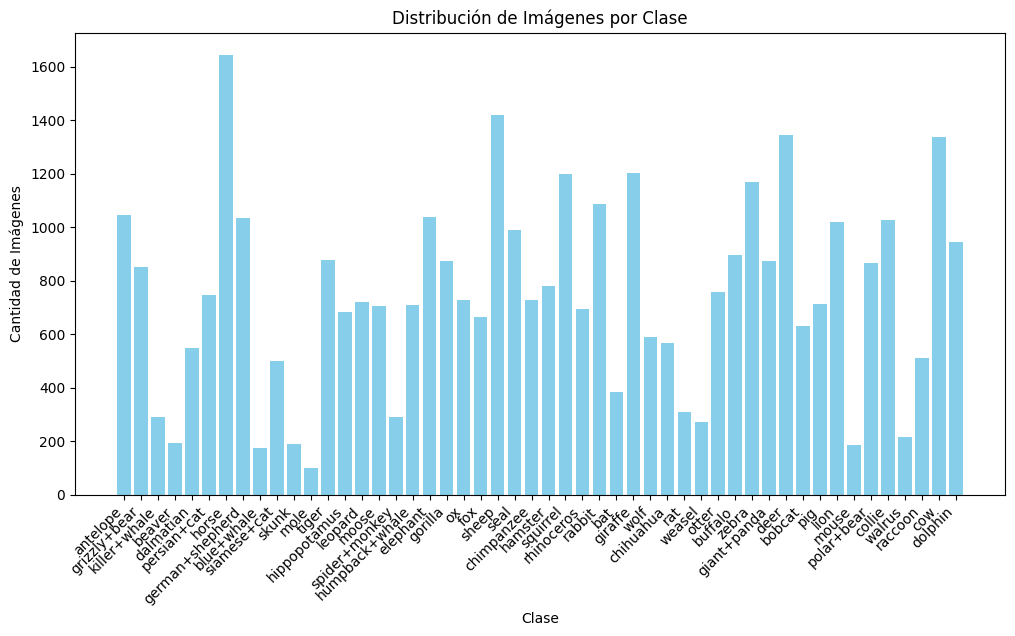

Least common attribute in dataset: flys with 383
Most common attributes in dataset: oldworld with 34097


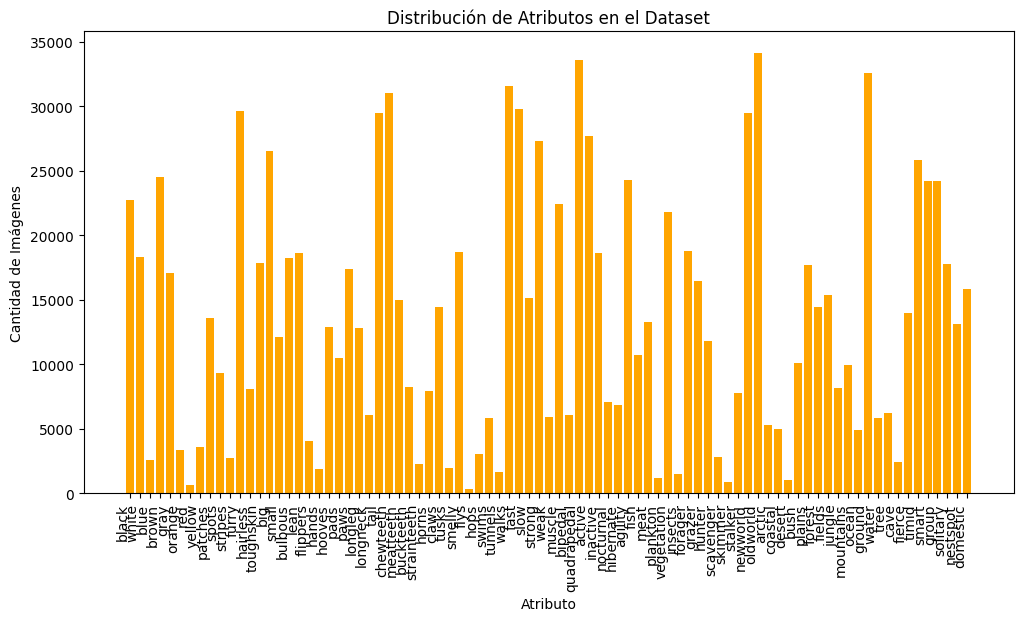

In [97]:
# Calcular el balance de imágenes por clase
class_counts = analyze_class_balance(dataset_path + "/JPEGImages", classes_dict)

# Calcular el balance de atributos basado en las clases seleccionadas
analyze_attribute_balance(class_counts, binary_matrix, classes_dict, attributes_dict)

Batch de imágenes: torch.Size([64, 3, 64, 64]), Batch de especies: torch.Size([64]), Batch de atributos: torch.Size([64, 3])

Least common attribute in dataset: blue with 0
Most common attributes in dataset: furry with 4409


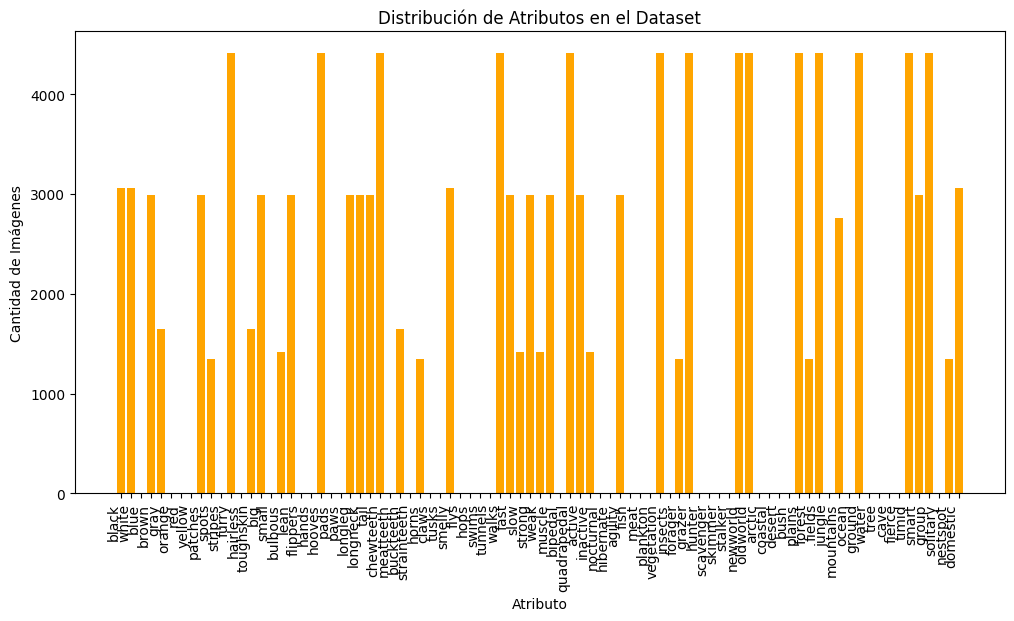

In [98]:
# Ruta al dataset
images_path = dataset_path + "/JPEGImages"

selected_classes = ["sheep","horse","deer"]  # Nombres de las especies
selected_attributes = ["oldworld","domestic","mountains"]  # Nombres de atributos
# Cargar clases y atributos
classes_dict = load_classes(classes_file)
attributes_dict = load_attributes(predicates_file)

# Filtrar clases y atributos
filtered_matrix, filtered_classes, filtered_attributes = load_filtered_data(
    predicate_matrix_file, selected_classes, selected_attributes, classes_dict, attributes_dict
)
# Reindexar clases y atributos
new_class_indices, new_attribute_indices = reindex_classes_and_attributes(filtered_classes, filtered_attributes)

# Crear dataset y dataloader
dataset = AnimalAttributesDataset(
    root=images_path, 
    transform=transform, 
    selected_classes=selected_classes, 
    selected_attributes=selected_attributes,
    classes_dict=classes_dict,
    attributes_dict=attributes_dict
)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Probar el DataLoader
for images, images_classes, attributes in dataloader:
    print(f"Batch de imágenes: {images.size()}, Batch de especies: {images_classes.size()}, Batch de atributos: {attributes.size()}")
    print()
    break

# Calcular el balance de atributos basado en las clases seleccionadas
analyze_attribute_balance(class_counts, binary_matrix, filtered_classes, attributes_dict)



{0: 'oldworld', 1: 'mountains', 2: 'domestic'}
Clases en el lote: ['horse', 'deer', 'sheep', 'sheep', 'deer', 'horse', 'deer', 'deer', 'horse', 'sheep', 'horse', 'deer', 'sheep', 'horse', 'deer', 'deer', 'horse', 'horse', 'horse', 'horse', 'sheep', 'horse', 'horse', 'sheep', 'horse', 'sheep', 'horse', 'horse', 'horse', 'deer', 'deer', 'deer', 'horse', 'deer', 'deer', 'horse', 'sheep', 'horse', 'horse', 'sheep', 'horse', 'horse', 'sheep', 'deer', 'sheep', 'deer', 'sheep', 'horse', 'horse', 'deer', 'sheep', 'deer', 'horse', 'deer', 'deer', 'sheep', 'horse', 'deer', 'sheep', 'sheep', 'sheep', 'horse', 'horse', 'sheep']
Atributos en el lote: [['oldworld', 'domestic'], ['oldworld', 'mountains'], ['oldworld', 'mountains', 'domestic'], ['oldworld', 'mountains', 'domestic'], ['oldworld', 'mountains'], ['oldworld', 'domestic'], ['oldworld', 'mountains'], ['oldworld', 'mountains'], ['oldworld', 'domestic'], ['oldworld', 'mountains', 'domestic'], ['oldworld', 'domestic'], ['oldworld', 'mountains'

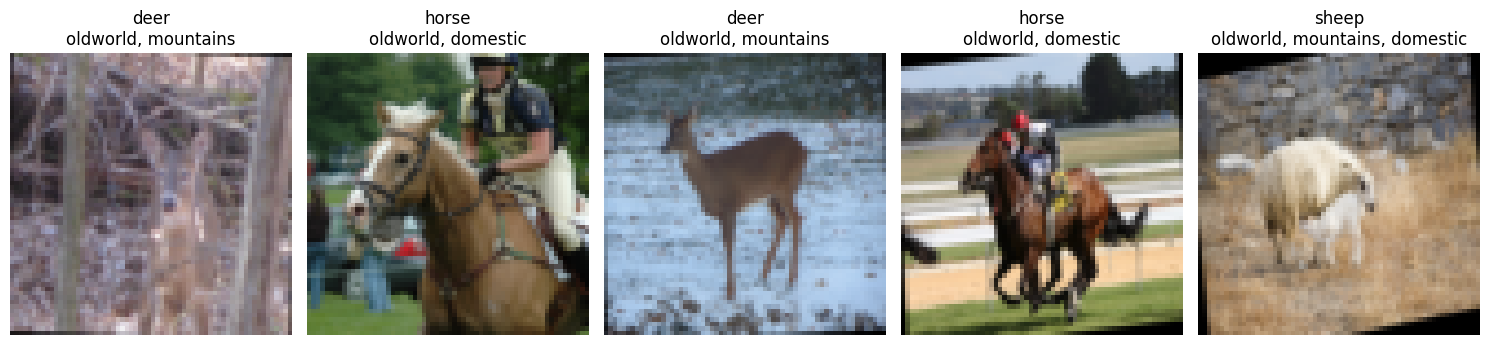

In [99]:


# Función mejorada para mostrar imágenes variadas
def show_varied_images(dataloader, filtered_classes, filtered_attributes, num_images=8):
    """
    Muestra imágenes del DataLoader con sus clases y atributos, seleccionando ejemplos variados.
    """
    # Obtener un lote del DataLoader
    all_images, all_attributes, all_classes = [], [], []
    
    # Iterar sobre varios lotes para recolectar datos
    for images, classes, attributes in dataloader:
        all_images.extend(images)
        all_attributes.extend(attributes)
        all_classes.extend(classes)
        if len(all_images) >= 100:  # Recolectar un número suficiente de ejemplos
            break
    new_class_indices, new_attribute_indices = reindex_classes_and_attributes(filtered_classes, filtered_attributes)
    reindexed_attributes = {new_idx: name for old_idx, new_idx in new_attribute_indices.items() for k, name in filtered_attributes.items() if k == old_idx}
    print(reindexed_attributes)
    for images, classes, attributes in dataloader:
        print("Clases en el lote:", [filtered_classes[c.item()] for c in classes])
        #print("Atributos en el lote:", attributes)
        print("Atributos en el lote:", [
            [reindexed_attributes[a] for a, val in enumerate(attr) if val == 1]
            for attr in attributes
        ])
        break
    # Convertir atributos y clases a nombres
    class_names = list(filtered_classes.values())
    attribute_names = list(filtered_attributes.values())

    all_attributes = torch.stack(all_attributes).numpy()  # Convertir atributos a numpy para conteo
    all_classes = torch.tensor(all_classes).numpy()  # Convertir clases a numpy para conteo

    # Seleccionar ejemplos variados aleatoriamente
    selected_indices = random.sample(range(len(all_images)), num_images)
    
    plt.figure(figsize=(15, 5))
    for idx, i in enumerate(selected_indices):
        img = all_images[i]
        attrs = [attribute_names[j] for j, val in enumerate(all_attributes[i]) if val == 1]
        cls = filtered_classes[all_classes[i].item()]

        # Deshacer normalización para visualizar correctamente
        img = img.permute(1, 2, 0).numpy()  # De [C, H, W] a [H, W, C]
        img = (img * 0.5 + 0.5).clip(0, 1)  # Revertir normalización (-1, 1) a (0, 1)

        plt.subplot(1, num_images, idx + 1)
        plt.imshow((img * 255).astype("uint8"))
        plt.axis('off')
        plt.title(f"{cls}\n" + (", ".join(attrs) if attrs else "No attributes"))

    plt.tight_layout()
    plt.show()

# Llamar a la función
show_varied_images(dataloader, filtered_classes, filtered_attributes, num_images=5)


In [100]:
# Fijamos la semilla para que los resultados sean reproducibles
#SEED = 34

#torch.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True

In [101]:
class CatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.endswith(('.jpg', '.png'))]  # Ajusta extensiones si es necesario

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Asegúrate de que sean RGB
        if self.transform:
            image = self.transform(image)
        return image

# Uso del dataset personalizado
#cat_dataset = CatsDataset(root_dir="/kaggle/input/cats-and-dogs/PetImages/Cat", transform=transform)
#dataloader = DataLoader(cat_dataset, batch_size=64, shuffle=True)

<class 'list'>


TypeError: can't multiply sequence by non-int of type 'float'

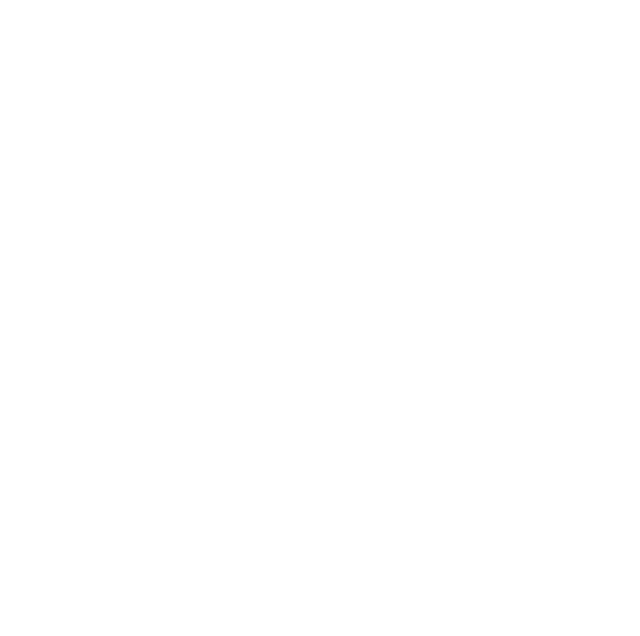

In [102]:
import torchvision.utils as vutils

# Visualizar un batch
data_iter = iter(dataloader)
images = next(data_iter)
print(type(images))

# Desnormalizar para visualizar
def denormalize(img):
    return img * 0.5 + 0.5  # Reescalar de [-1, 1] a [0, 1]

# Mostrar imágenes
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(vutils.make_grid(denormalize(images), nrow=8).permute(1, 2, 0))
plt.show()

In [ ]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Usando {DEVICE}")

NUM_WORKERS = 3  # numero de workers para cargar los datos
BATCH_SIZE = 128  # tamaño del batch

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def calculate_output_dim(self,input_dim, kernel_size, stride=1, padding=0, dilation=1):
        """
        Calcula la dimensión de salida de un tensor después de una capa de convolución.
    
        Args:
            input_dim (int): Dimensión de entrada (altura o ancho).
            kernel_size (int): Tamaño del kernel de convolución.
            stride (int): Tamaño del paso de la convolución (por defecto 1).
            padding (int): Tamaño del padding aplicado (por defecto 0).
            dilation (int): Factor de dilatación del kernel (por defecto 1).
    
        Returns:
            int: Dimensión de salida.
        """
        return ((input_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

    def calculate_output_transpose(self,input_dim, kernel_size, stride=1, padding=0):
        """
        Calcula la dimensión de salida de un tensor después de una capa de convolución.
    
        Args:
            input_dim (int): Dimensión de entrada (altura o ancho).
            kernel_size (int): Tamaño del kernel de convolución.
            stride (int): Tamaño del paso de la convolución (por defecto 1).
            padding (int): Tamaño del padding aplicado (por defecto 0).
            dilation (int): Factor de dilatación del kernel (por defecto 1).
    
        Returns:
            int: Dimensión de salida.
        """
        return (input_dim-1)*stride-2*padding+kernel_size

    def __init__(self, image_size, latent_dim, attr_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.attr_dim = attr_dim
        self.image_size = image_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, H/2, W/2]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # [B, 64, H/4, W/4]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # [B, 64, H/4, W/4]
            nn.ReLU(),
            nn.Flatten()
        )
        
        output_conv_dim = self.image_size
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 4, stride=2, padding=1)
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 4, stride=2, padding=1)
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 3, stride=2, padding=1) #[B, 64, H/4, W/4]
        #output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 3, stride=3, padding=1)
        self.output_conv_dim = output_conv_dim
        flat_dim = 128 * (self.output_conv_dim**2)
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        # Decoder
        self.decoder_input = nn.Linear(latent_dim + attr_dim, flat_dim)
        #self.decoder_input = nn.Linear(latent_dim, flat_dim)
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(96, 64, kernel_size=3, stride=3, padding=0), 
            #nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 32, H/4, W/4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # [B, 3, H, W]
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Escala a [-1, 1] para imágenes
        )
        #output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=3, stride=3, padding=0)
        output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=3, stride=2, padding=1)
        output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=4, stride=2, padding=1)
        output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=4, stride=2, padding=1)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        #return mu + eps * std
        return mu+eps*logvar
    
    def decode(self, z, attrs=None):
        z_cond = z
        if attrs != None:
            #attrs = attrs.unsqueeze(0)
            z_cond = torch.cat([z, attrs], dim=1)
        h = self.decoder_input(z_cond)
        h = h.view(h.size(0), 128, self.output_conv_dim, self.output_conv_dim)  # Reestructurar para convoluciones
        return self.decoder(h)
    
    def forward(self, x, attrs):
        # Encode
        mu, logvar = self.encode(x)
        sdev = torch.exp(0.5 * logvar)
        z = self.reparameterize(mu, sdev)
        
        # Decode
        recon_x = self.decode(z, attrs)
        
        return recon_x, mu, logvar

In [ ]:
class VAE(nn.Module):
    def calculate_output_dim(self,input_dim, kernel_size, stride=1, padding=0, dilation=1):
        """
        Calcula la dimensión de salida de un tensor después de una capa de convolución.
    
        Args:
            input_dim (int): Dimensión de entrada (altura o ancho).
            kernel_size (int): Tamaño del kernel de convolución.
            stride (int): Tamaño del paso de la convolución (por defecto 1).
            padding (int): Tamaño del padding aplicado (por defecto 0).
            dilation (int): Factor de dilatación del kernel (por defecto 1).
    
        Returns:
            int: Dimensión de salida.
        """
        return ((input_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

    def calculate_output_transpose(self,input_dim, kernel_size, stride=1, padding=0):
        """
        Calcula la dimensión de salida de un tensor después de una capa de convolución.
    
        Args:
            input_dim (int): Dimensión de entrada (altura o ancho).
            kernel_size (int): Tamaño del kernel de convolución.
            stride (int): Tamaño del paso de la convolución (por defecto 1).
            padding (int): Tamaño del padding aplicado (por defecto 0).
            dilation (int): Factor de dilatación del kernel (por defecto 1).
    
        Returns:
            int: Dimensión de salida.
        """
        return (input_dim-1)*stride-2*padding+kernel_size

    def __init__(self, image_size, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.attr_dim = attr_dim
        self.image_size = image_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        output_conv_dim = self.image_size
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 4, stride=2, padding=1)
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 4, stride=2, padding=1)
        output_conv_dim = self.calculate_output_dim(output_conv_dim, kernel_size = 4, stride=2, padding=1)
        self.output_conv_dim = output_conv_dim
        flat_dim = 256 * (output_conv_dim**2)
        self.fc_mu = nn.Linear(flat_dim, latent_dim)       # Media
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)   # Log-varianza
        
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        
        # Decoder
        #self.decoder_input = nn.Linear(latent_dim + attr_dim, flat_dim)
        self.fc = nn.Linear(latent_dim, flat_dim)  # Expandir espacio latente a 4x4x256
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # Valores entre -1 y 1
        )
        #output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=3, stride=2, padding=1)
        output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=4, stride=2, padding=2)
        output_size=self.calculate_output_transpose(output_conv_dim, kernel_size=4, stride=2, padding=2)
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        #std = torch.exp(0.5 * logvar)
        #eps = torch.randn_like(std)
        eps = torch.randn_like(mu)
        #return mu + eps * std
        return mu+eps*logvar
    
    def decode(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 256, self.output_conv_dim, self.output_conv_dim)  # Reestructurar para convoluciones
        return self.decoder(h)
    
    def forward(self, x):
        # Encode
        mu, logvar = self.encode(x)
        sdev = torch.exp(0.5 * logvar)
        z = self.reparameterize(mu, sdev)
        
        # Decode
        recon_x = self.decode(z)
        
        return recon_x, mu, logvar

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



class VAE2(nn.Module):
    def __init__(self, block, layers, latent_variable_size, nc, ngf, ndf, is_cuda=False):
        super(VAE2, self).__init__()
        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.is_cuda = is_cuda
        #Encoder
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, 512)
        self.fc1 = nn.Linear(512 , latent_variable_size)
        self.fc2 = nn.Linear(512 , latent_variable_size)
        
        #Decoder
        self.fc3 = nn.Linear(latent_variable_size, 500)
        self.fc4 = nn.Linear(500, 14*14*32)
        self.deconv1 = nn.ConvTranspose2d(32,64, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32,16, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16,3, kernel_size=3, stride =2, padding=1, output_padding=1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def encode(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        #print((x>0.000).sum())
        w_mean = self.fc1(x)
        w_std  = self.fc2(x)
        return w_mean, w_std

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if self.is_cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        x = self.fc3(z)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        #print(x.size())
        #print((x>0.000).sum())
        x = x.view(-1,32,14,14)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.deconv4(x)
        x = self.sigmoid(x)

        return x

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar

In [128]:
# Define las dimensiones de entrada
BATCH_SIZE = 64
image_size = 64
latent_dim = 400
attr_dim = 3

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# Crea datos ficticios para la imagen y los atributos
dummy_images = torch.randn(BATCH_SIZE, 3, image_size, image_size)  # [B, C, H, W]
dummy_attrs = torch.randn(BATCH_SIZE, attr_dim)  # [B, attr_dim]

# Instancia el modelo
model = CVAE(image_size=image_size, latent_dim=latent_dim, attr_dim=attr_dim)

# Usa torchinfo.summary con input_data
summary(
    model,
    input_data=(dummy_images,dummy_attrs),
    col_names=["input_size", "output_size", "num_params"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVAE                                     [64, 3, 64, 64]           [64, 3, 64, 64]           --
├─Sequential: 1-1                        [64, 3, 64, 64]           [64, 8192]                --
│    └─Conv2d: 2-1                       [64, 3, 64, 64]           [64, 32, 32, 32]          1,568
│    └─ReLU: 2-2                         [64, 32, 32, 32]          [64, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 32, 32, 32]          [64, 64, 16, 16]          32,832
│    └─ReLU: 2-4                         [64, 64, 16, 16]          [64, 64, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 64, 16, 16]          [64, 128, 8, 8]           131,200
│    └─ReLU: 2-6                         [64, 128, 8, 8]           [64, 128, 8, 8]           --
│    └─Flatten: 2-7                      [64, 128, 8, 8]           [64, 8192]                --
├─Linear: 1-2          

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CVAE                                     [64, 3, 64, 64]           [64, 3, 64, 64]           --
├─Sequential: 1-1                        [64, 3, 64, 64]           [64, 8192]                --
│    └─Conv2d: 2-1                       [64, 3, 64, 64]           [64, 32, 32, 32]          1,568
│    └─ReLU: 2-2                         [64, 32, 32, 32]          [64, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 32, 32, 32]          [64, 64, 16, 16]          32,832
│    └─ReLU: 2-4                         [64, 64, 16, 16]          [64, 64, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 64, 16, 16]          [64, 128, 8, 8]           131,200
│    └─ReLU: 2-6                         [64, 128, 8, 8]           [64, 128, 8, 8]           --
│    └─Flatten: 2-7                      [64, 128, 8, 8]           [64, 8192]                --
├─Linear: 1-2          

In [129]:
def loss_function(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss

def visualize_recon(recon_x, x, num_samples):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Original
        plt.subplot(2, 1, i + 1)
        img = x[i].permute(1, 2, 0).cpu().detach().numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original")
        
        # Reconstruido
        plt.subplot(2, 1, num_samples + i + 1)
        recon_img = recon_x[i].permute(1, 2, 0).cpu().detach().numpy()
        recon_img = (recon_img * 0.5 + 0.5).clip(0, 1)
        plt.imshow(recon_img)
        plt.axis('off')
        plt.title("Reconstruido")
    
    plt.tight_layout()
    plt.show()

In [130]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CVAE(image_size=64, latent_dim=400, attr_dim=1).to(device)
#model = VAE(image_size=32, latent_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
beta=1

epochs = 30
def train_cat(model, optimizer, criterion,epochs, device, beta):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for images in dataloader:
            images = images.to(device)
            attrs = torch.tensor([1])
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images, attrs)
            #recon_images, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar, beta)
            #recon_loss = criterion(recon_images, images)
            #kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   
            #loss = recon_loss + beta * kl_loss
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
        if (epoch+1) % 4 == 0:    
            torch.save(model.state_dict(),"model_cvae.pth")
        visualize_recon(recon_images, images, 1)
        print(f"Epoch {epoch+1}, Loss: {overall_loss / len(images)}")

In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CVAE(image_size=64, latent_dim=400, attr_dim=3).to(device)
#model = VAE(image_size=32, latent_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
beta=1

epochs = 20
def train(model, optimizer, criterion,epochs, device, beta):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for images, _, attrs in dataloader:
            images, attrs = images.to(device), attrs.to(device)
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images, attrs)
            #recon_images, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar, beta)
            #recon_loss = criterion(recon_images, images)
            #kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   
            #loss = recon_loss + beta * kl_loss
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
        if (epoch+1) % 4 == 0:    
            torch.save(model.state_dict(),"model_cvae.pth")
            visualize_recon(recon_images, images, 1)
        print(f"Epoch {epoch+1}, Loss: {overall_loss / len(images)}")

Epoch 1, Loss: 216364.82976973685
Epoch 2, Loss: 148806.61211622806
Epoch 3, Loss: 108090.00945723684


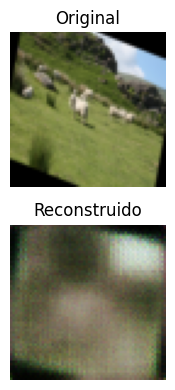

Epoch 4, Loss: 94803.6369243421
Epoch 5, Loss: 88686.93969298246
Epoch 6, Loss: 84599.11821546052
Epoch 7, Loss: 81382.03330592105


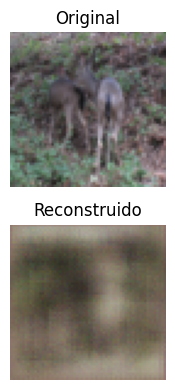

Epoch 8, Loss: 78562.14384594298
Epoch 9, Loss: 75684.87705592105
Epoch 10, Loss: 73623.75301535087
Epoch 11, Loss: 71757.08031798246


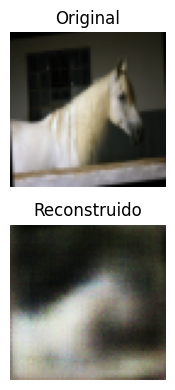

Epoch 12, Loss: 70107.62691885965
Epoch 13, Loss: 68724.42132675438
Epoch 14, Loss: 67591.1798245614
Epoch 15, Loss: 66384.78707510965


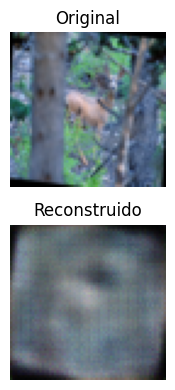

Epoch 16, Loss: 65323.54584703947
Epoch 17, Loss: 64293.21977796053
Epoch 18, Loss: 63358.218612938595
Epoch 19, Loss: 62431.67502741228


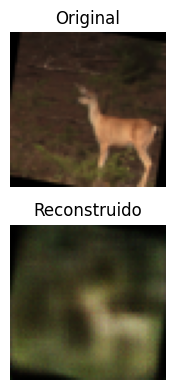

Epoch 20, Loss: 61427.57894736842


In [132]:
train(model, optimizer, criterion,epochs, device, beta)

In [133]:
def visualize_reconstruction(model, dataloader, num_samples=5):
    model.eval()
    #images, _, attrs = next(iter(dataloader))
    #images, attrs = images[:num_samples].to(device), attrs[:num_samples].to(device)
    images = next(iter(dataloader))
    images = images[:num_samples].to(device)
    with torch.no_grad():
        #recon_images, _, _ = model(images, attrs)
        recon_images = model(images, attrs=None)
    
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Original
        plt.subplot(2, num_samples, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original")
        
        # Reconstruido
        plt.subplot(2, num_samples, num_samples + i + 1)
        recon_img = recon_images[i].permute(1, 2, 0).cpu().numpy()
        recon_img = (recon_img * 0.5 + 0.5)#.clip(0, 1)
        plt.imshow(recon_img)
        plt.axis('off')
        plt.title("Reconstruido")
    
    plt.tight_layout()
    plt.show()


In [135]:
def generate_images(model, attributes, num_samples=5):
    """
    Genera imágenes a partir de atributos seleccionados.
    """ 
    model.eval()
    sampled_z = torch.randn((num_samples, model.latent_dim)).to(device)  # Muestrea z ~ N(0, 1)
    attributes = torch.tensor(attributes).float().to(device)            # Atributos binarios
    attributes = attributes.expand(num_samples, -1)  # Expande atributos para igualar el batch size
    #print(f"Attribute_size: {attributes.shape}")
    #print(f"z_size: {sampled_z.shape}")
    #generated_images = model.decode(sampled_z, attributes)
    #generated_images = generated_images.detach().cpu()
    with torch.no_grad():
        generated_images = model.decode(sampled_z, attributes)
    
    # Mostrar imágenes generadas
    plt.figure(figsize=(12, 3))
    for i, img in enumerate(generated_images):
        img = (img * 0.5 + 0.5).clip(0, 1)       # Desnormalizar
        img = img.permute(1, 2, 0).cpu().detach().numpy()  # Convertir a [H, W, C]
        #img = (img + 1)/2
        plt.subplot(1, num_samples, i + 1)
        #plt.imshow((img * 255).astype("uint8"))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


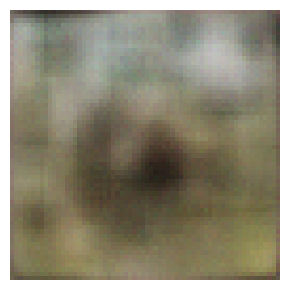

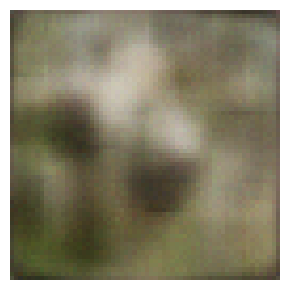

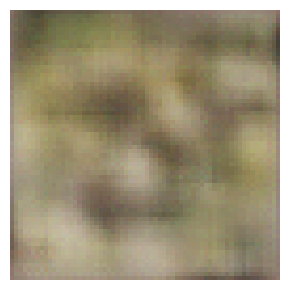

In [140]:
attributes_in = [
    [1,1,1],
    [1,1,0],
    [1,0,1],
]

for attrs in attributes_in:
    generate_images(model, attrs, num_samples=1)

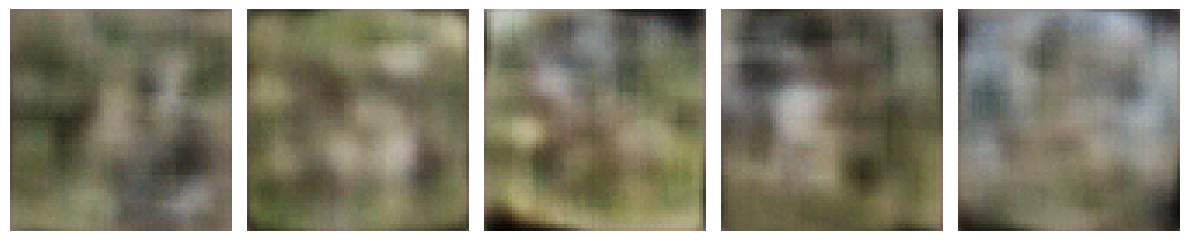

In [137]:
attributes_in = [1,1,1]
generate_images(model, attributes_in)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

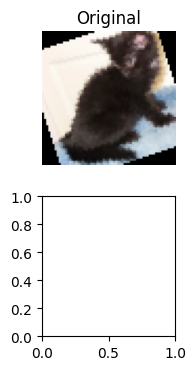

In [101]:
visualize_reconstruction(model, dataloader, 5)